Generative Adverserial Networks (MNIST)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
'''
Step 1
'''
bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [3]:
'''
Step 2
'''

class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))
    


In [4]:
'''
Step 3-1
'''

z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2) # =784

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

criterion = nn.BCELoss() 
G_optimizer = optim.Adam(G.parameters(), lr = 0.0002)
D_optimizer = optim.Adam(D.parameters(), lr = 0.0002)


/home/kagok/anaconda3/envs/ksh/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [5]:
'''
Step 3-2
'''

def D_train(x):
    
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

def G_train(x):
    
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [6]:
'''
Step 4
'''

import time
start = time.time()

n_epoch = 200

for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

end = time.time()
print("Time ellapsed in training is: {}".format(end - start))

[1/200]: loss_d: 0.833, loss_g: 3.515
[2/200]: loss_d: 1.060, loss_g: 2.095
[3/200]: loss_d: 0.985, loss_g: 1.975
[4/200]: loss_d: 0.780, loss_g: 2.384
[5/200]: loss_d: 0.414, loss_g: 3.346
[6/200]: loss_d: 0.475, loss_g: 3.116
[7/200]: loss_d: 0.518, loss_g: 2.771
[8/200]: loss_d: 0.565, loss_g: 2.669
[9/200]: loss_d: 0.598, loss_g: 2.506
[10/200]: loss_d: 0.651, loss_g: 2.364
[11/200]: loss_d: 0.671, loss_g: 2.340
[12/200]: loss_d: 0.702, loss_g: 2.165
[13/200]: loss_d: 0.696, loss_g: 2.264
[14/200]: loss_d: 0.756, loss_g: 2.067
[15/200]: loss_d: 0.748, loss_g: 2.084
[16/200]: loss_d: 0.776, loss_g: 1.985
[17/200]: loss_d: 0.795, loss_g: 1.940
[18/200]: loss_d: 0.801, loss_g: 1.952
[19/200]: loss_d: 0.869, loss_g: 1.695
[20/200]: loss_d: 0.860, loss_g: 1.728
[21/200]: loss_d: 0.905, loss_g: 1.637
[22/200]: loss_d: 0.891, loss_g: 1.670
[23/200]: loss_d: 0.945, loss_g: 1.518
[24/200]: loss_d: 0.912, loss_g: 1.623
[25/200]: loss_d: 0.949, loss_g: 1.549
[26/200]: loss_d: 0.967, loss_g: 1

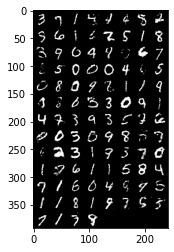

In [12]:
'''
Step 5
'''

with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    save_image(generated.view(generated.size(0), 1, 28, 28), 'sample_' + '.png')

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img = mpimg.imread('sample_.png')
plt.imshow(img)
plt.show()